In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs

In [4]:
MEGAb_TO_b = 1e6
TCP_DOWN = "*down.*.csv"
UDP_DOWN = "*down*udp*.csv"
TCP_UP = "*receive.*[!p].csv"
UDP_UP = "*receive*.udp.csv"
TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'

In [5]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [6]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [7]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    convert_to_mb(combined_df)
    combined_df = combined_df[keep]
    return combined_df

In [8]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    df_map.iloc[:,0] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [9]:
def combine_reg(src, pattern, keep='bandwidth', first=3):
    regions_df = pd.DataFrame()
    start = True
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, [keep]).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df.rename(columns={keep: reg_name}, inplace=True)
        combined_df = remove_first_measures(combined_df, first)

        if start:
            regions_df = combined_df
            start = False
        else:
            regions_df = pd.merge(regions_df, combined_df, how='outer', left_index=True, right_index=True)

    return regions_df

In [17]:
from ipyfilechooser import FileChooser

# Create and display a FileChooser widget
fc = FileChooser('data/Home_network_data/')
fc.sandbox_path = 'data/Home_network_data/'
display(fc)

FileChooser(path='/home/sami/starlink-plot/data/Home_network_data', filename='', title='', show_hidden=False, …

In [18]:
fc1 = FileChooser('data/starlink-data/')
fc1.sandbox_path = 'data/starlink-data/'
display(fc1)

FileChooser(path='/home/sami/starlink-plot/data/starlink-data', filename='', title='', show_hidden=False, sele…

In [41]:
#src_dirs = [('Starlink', 'data/Starlink_csv_2022_04-07_to_04-12/')]
#src_dirs = [('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/')]
src_dirs = []
if fc1.selected_path:
    src_dirs.append(('Starlink', fc1.selected_path))
if fc.selected_path:
    src_dirs.append(('Home', fc.selected_path))
src_dirs

[('Starlink',
  '/home/sami/starlink-plot/data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp')]

In [49]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    #df = concat_df(args.src_folder, UDP_UP, [JITTER])
    df_temp = combine_reg(folder, TCP_DOWN, first=1)
    df_temp = pd.concat({type_name: df_temp}, axis=1)
    if not df.empty:
        df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
    else:
        df = df_temp
df

Starlink                         \
                              South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                                      
2022-01-23 05:45:50.000000000                     NaN                    NaN   
2022-01-23 05:45:51.000224768                     NaN                    NaN   
2022-01-23 05:45:52.000106752                     NaN                    NaN   
2022-01-23 05:45:53.000109824                     NaN                    NaN   
2022-01-23 05:45:54.000188160                     NaN                    NaN   
...                                               ...                    ...   
2022-02-19 22:42:08.000073984                     NaN                    NaN   
2022-02-19 22:42:09.000030976                     NaN                    NaN   
2022-02-19 22:42:10.000027904                     NaN                    NaN   
2022-02-19 22:42:11.000109056                     NaN                    NaN   
2022-02-19 22:42:12.000409856                     NaN                    NaN   

                                                                        \
                              Asia_Pacific_Sydney US_West_N_California   
timestamp                                                                
2022-01-23 05:45:50.000000000           -1.000000                  NaN   
2022-01-23 05:45:51.000224768            7.727440                  NaN   
2022-01-23 05:45:52.000106752            9.313507                  NaN   
2022-01-23 05:45:53.000109824            8.351413                  NaN   
2022-01-23 05:45:54.000188160           13.079434                  NaN   
...                                           ...                  ...   
2022-02-19 22:42:08.000073984                 NaN            86.802637   
2022-02-19 22:42:09.000030976                 NaN            87.749072   
2022-02-19 22:42:10.000027904                 NaN            86.745544   
2022-02-19 22:42:11.000109056                 NaN           101.653766   
2022-02-19 22:42:12.000409856                 NaN            98.884261   

                                                                      \
                              Middle_East_Bahrain Asia_Pacific_Tokyo   
timestamp                                                              
2022-01-23 05:45:50.000000000                 NaN                NaN   
2022-01-23 05:45:51.000224768                 NaN                NaN   
2022-01-23 05:45:52.000106752                 NaN                NaN   
2022-01-23 05:45:53.000109824                 NaN                NaN   
2022-01-23 05:45:54.000188160                 NaN                NaN   
...                                           ...                ...   
2022-02-19 22:42:08.000073984                 NaN                NaN   
2022-02-19 22:42:09.000030976                 NaN                NaN   
2022-02-19 22:42:10.000027904                 NaN                NaN   
2022-02-19 22:42:11.000109056                 NaN                NaN   
2022-02-19 22:42:12.000409856                 NaN                NaN   

                                                                 
                              Europe_London Asia_Pacific_Mumbai  
timestamp                                                        
2022-01-23 05:45:50.000000000           NaN                 NaN  
2022-01-23 05:45:51.000224768           NaN                 NaN  
2022-01-23 05:45:52.000106752           NaN                 NaN  
2022-01-23 05:45:53.000109824           NaN                 NaN  
2022-01-23 05:45:54.000188160           NaN                 NaN  
...                                     ...                 ...  
2022-02-19 22:42:08.000073984           NaN                 NaN  
2022-02-19 22:42:09.000030976           NaN                 NaN  
2022-02-19 22:42:10.000027904           NaN                 NaN  
2022-02-19 22:42:11.000109056           NaN                 NaN  
2022-02-19 22:42:12.

In [43]:
df_regs = df.replace(-1, pd.NA)
df_regs = df_regs.dropna(how='all').astype(float)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')
#df_regs = df_regs.loc['2022-05-28 18:13:00':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']

df_regs

Starlink                         \
                              South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                                      
2022-01-23 05:45:51.000224768                     NaN                    NaN   
2022-01-23 05:45:52.000106752                     NaN                    NaN   
2022-01-23 05:45:53.000109824                     NaN                    NaN   
2022-01-23 05:45:54.000188160                     NaN                    NaN   
2022-01-23 05:45:55.000103936                     NaN                    NaN   
...                                               ...                    ...   
2022-02-19 22:42:08.000073984                     NaN                    NaN   
2022-02-19 22:42:09.000030976                     NaN                    NaN   
2022-02-19 22:42:10.000027904                     NaN                    NaN   
2022-02-19 22:42:11.000109056                     NaN                    NaN   
2022-02-19 22:42:12.000409856                     NaN                    NaN   

                                                                        \
                              Asia_Pacific_Sydney US_West_N_California   
timestamp                                                                
2022-01-23 05:45:51.000224768            7.727440                  NaN   
2022-01-23 05:45:52.000106752            9.313507                  NaN   
2022-01-23 05:45:53.000109824            8.351413                  NaN   
2022-01-23 05:45:54.000188160           13.079434                  NaN   
2022-01-23 05:45:55.000103936           16.599025                  NaN   
...                                           ...                  ...   
2022-02-19 22:42:08.000073984                 NaN            86.802637   
2022-02-19 22:42:09.000030976                 NaN            87.749072   
2022-02-19 22:42:10.000027904                 NaN            86.745544   
2022-02-19 22:42:11.000109056                 NaN           101.653766   
2022-02-19 22:42:12.000409856                 NaN            98.884261   

                                                                      \
                              Middle_East_Bahrain Asia_Pacific_Tokyo   
timestamp                                                              
2022-01-23 05:45:51.000224768                 NaN                NaN   
2022-01-23 05:45:52.000106752                 NaN                NaN   
2022-01-23 05:45:53.000109824                 NaN                NaN   
2022-01-23 05:45:54.000188160                 NaN                NaN   
2022-01-23 05:45:55.000103936                 NaN                NaN   
...                                           ...                ...   
2022-02-19 22:42:08.000073984                 NaN                NaN   
2022-02-19 22:42:09.000030976                 NaN                NaN   
2022-02-19 22:42:10.000027904                 NaN                NaN   
2022-02-19 22:42:11.000109056                 NaN                NaN   
2022-02-19 22:42:12.000409856                 NaN                NaN   

                                                                 
                              Europe_London Asia_Pacific_Mumbai  
timestamp                                                        
2022-01-23 05:45:51.000224768           NaN                 NaN  
2022-01-23 05:45:52.000106752           NaN                 NaN  
2022-01-23 05:45:53.000109824           NaN                 NaN  
2022-01-23 05:45:54.000188160           NaN                 NaN  
2022-01-23 05:45:55.000103936           NaN                 NaN  
...                                     ...                 ...  
2022-02-19 22:42:08.000073984           NaN                 NaN  
2022-02-19 22:42:09.000030976           NaN                 NaN  
2022-02-19 22:42:10.000027904           NaN                 NaN  
2022-02-19 22:42:11.000109056           NaN                 NaN  
2022-02-19 22:42:12.

In [65]:
# Aggreagation options
df_regs_interp = df_regs
df_regs_interp = df_regs_interp.resample('H').mean()
df_regs_interp = df_regs_interp.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


Starlink                         \
                    South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                            
2022-01-23 05:00:00                     NaN                    NaN   
2022-01-23 06:00:00                     NaN                    NaN   
2022-01-23 07:00:00                     NaN                    NaN   
2022-01-23 08:00:00                     NaN                    NaN   
2022-01-23 09:00:00                     NaN                    NaN   
...                                     ...                    ...   
2022-02-19 18:00:00              105.100351             109.955001   
2022-02-19 19:00:00              104.457675             108.875664   
2022-02-19 20:00:00              103.814998             107.796326   
2022-02-19 21:00:00              103.172322             106.716989   
2022-02-19 22:00:00              102.529646             105.637652   

                                                              \
                    Asia_Pacific_Sydney US_West_N_California   
timestamp                                                      
2022-01-23 05:00:00           16.670687                  NaN   
2022-01-23 06:00:00           18.322454                  NaN   
2022-01-23 07:00:00           19.974221                  NaN   
2022-01-23 08:00:00           21.625988                  NaN   
2022-01-23 09:00:00           23.277755                  NaN   
...                                 ...                  ...   
2022-02-19 18:00:00          125.603151           170.688804   
2022-02-19 19:00:00          125.603151           170.669147   
2022-02-19 20:00:00          125.603151           170.649490   
2022-02-19 21:00:00          125.603151           170.629833   
2022-02-19 22:00:00          125.603151           170.610176   

                                                                          \
                    Middle_East_Bahrain Asia_Pacific_Tokyo Europe_London   
timestamp                                                                  
2022-01-23 05:00:00                 NaN                NaN           NaN   
2022-01-23 06:00:00                 NaN                NaN           NaN   
2022-01-23 07:00:00                 NaN                NaN           NaN   
2022-01-23 08:00:00                 NaN                NaN           NaN   
2022-01-23 09:00:00                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-02-19 18:00:00          102.937528         100.712472    120.206664   
2022-02-19 19:00:00          102.574452          99.076515    120.195073   
2022-02-19 20:00:00          102.211375          97.440558    120.183481   
2022-02-19 21:00:00          101.848299          95.804601    120.171890   
2022-02-19 22:00:00          101.485222          94.168644    120.160299   

                                         
                    Asia_Pacific_Mumbai  
timestamp                                
2022-01-23 05:00:00                 NaN  
2022-01-23 06:00:00                 NaN  
2022-01-23 07:00:00                 NaN  
2022-01-23 08:00:00                 NaN  
2022-01-23 09:00:00                 NaN  
...                                 ...  
2022-02-19 18:00:00           72.534242  
2022-02-19 19:00:00           71.623609  
2022-02-19 20:00:00           70.712976  
2022-02-19 21:00:00           69.802342  
2022-02-19 22:00:00           68.891709  

[666 rows x 8 columns]

In [66]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'

df_unstacked = df_regs_interp.unstack().dropna(how=all)
df_unstacked = df_unstacked.mask(df_unstacked == -1).reset_index(name=BANDWIDTH)
df_unstacked.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)

df_unstacked

,Type,Regions,timestamp,bandwidth
0,Starlink,South_America_Sao_Paulo,2022-01-24 04:00:00,57.129469
1,Starlink,South_America_Sao_Paulo,2022-01-24 05:00:00,56.928520
2,Starlink,South_America_Sao_Paulo,2022-01-24 06:00:00,56.780314
3,Starlink,South_America_Sao_Paulo,2022-01-24 07:00:00,56.684853
4,Starlink,South_America_Sao_Paulo,2022-01-24 08:00:00,56.642136
...,...,...,...,...
5170,Starlink,Asia_Pacific_Mumbai,2022-02-19 18:00:00,72.534242
5171,Starlink,Asia_Pacific_Mumbai,2022-02-19 19:00:00,71.623609
5172,Starlink,Asia_Pacific_Mumbai,2022-02-19 20:00:00,70.712976
5173,Starlink,Asia_Pacific_Mumbai,2022-02-19 21:00:00,69.802342


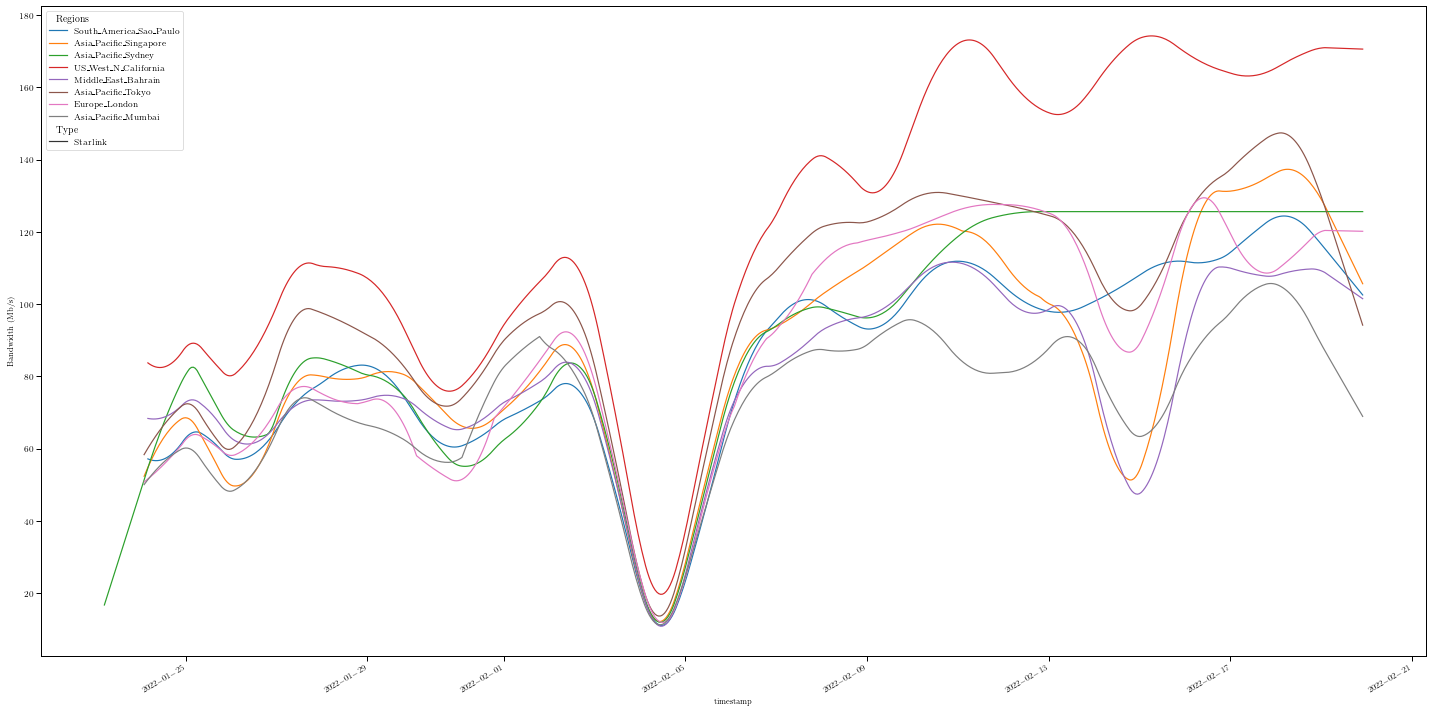

In [67]:
#fig, ax = plt.subplots(figsize=(3.5,3))
fig, ax = plt.subplots(figsize=(20,10))

ax.xaxis.update_units(df.index)
y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
ax.set_ylabel("Bandwidth (Mb/s)")
fig.tight_layout()

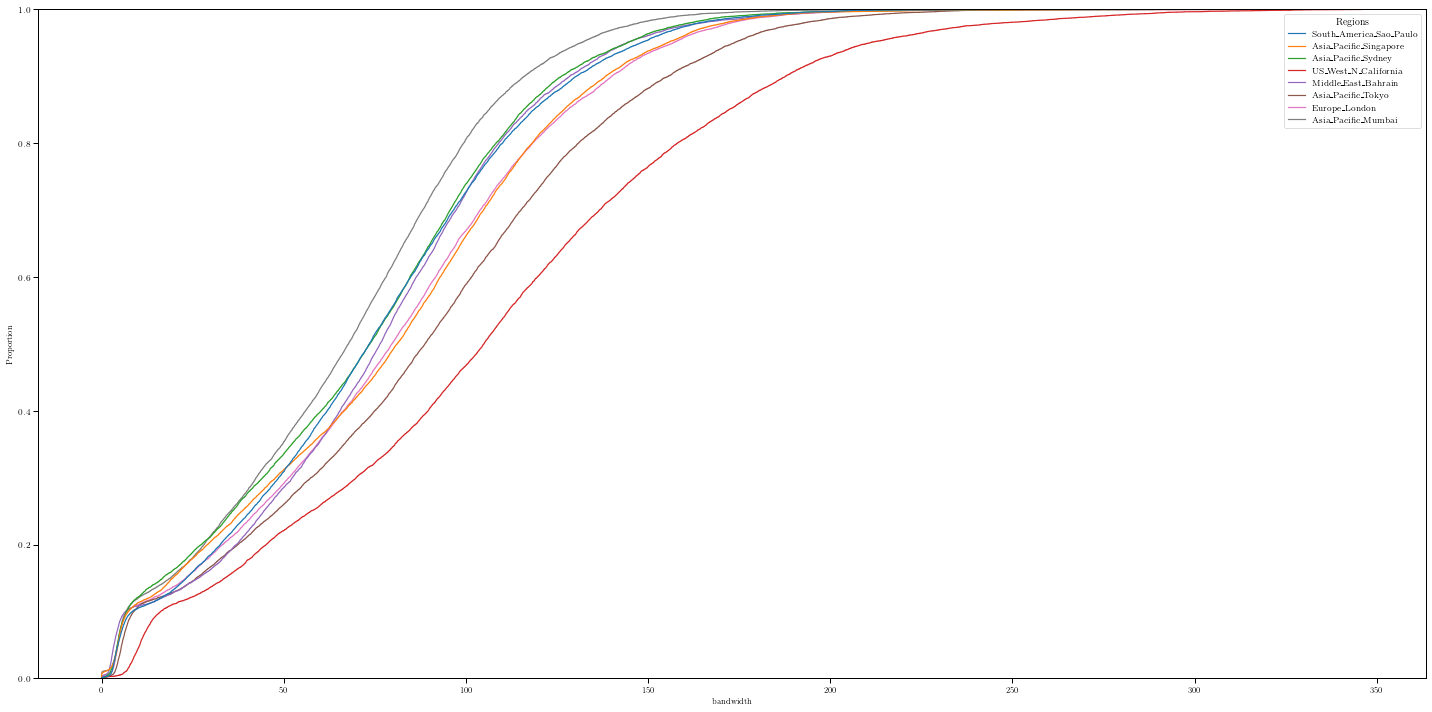

In [63]:
fig2, ax2 = plt.subplots(figsize=(20,10))
sns.ecdfplot(data=df_unstacked, x='bandwidth', hue=N_REGIONS)
fig2.tight_layout()

In [68]:
fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')